# **Capitulo 3 – Dimensionality Reduction**

# Setup

Como hicimos en Notebooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/dim_reduction` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Reducción de la dimensionalidad

Muchos problemas de Machine Learning implican miles o incluso millones de características para cada instancia de entrenamiento. Todas estas características no sólo hacen que el entrenamiento sea extremadamente lento, sino que también pueden hacer que sea mucho más difícil encontrar una buena solución. Este problema se conoce a menudo como la maldición de la dimensionalidad. Afortunadamente, en los problemas del mundo real, a menudo es posible reducir considerablemente el número de características, convirtiendo un problema intratable en uno manejable. Por ejemplo, consideremos las imágenes MNIST: los píxeles de los bordes de la imagen son casi siempre blancos, por lo que se podrían eliminar completamente del conjunto de entrenamiento sin perder mucha información. Como vimos en el Notebook anterior, confirmamos que estos píxeles carecen totalmente de importancia para la tarea de clasificación. Además, dos píxeles vecinos suelen estar muy correlacionados: si los fusiona en un único píxel (por ejemplo, tomando la media de las intensidades de los dos píxeles), no perderá mucha información.

La reducción de la dimensionalidad provoca cierta pérdida de información, al igual que la compresión de una imagen en JPEG puede degradar su calidad, por lo que, aunque acelerará el entrenamiento, puede hacer que su sistema funcione ligeramente peor. También hace que los procesos sean un poco más complejos y, por tanto, más difíciles de mantener. Por lo tanto, es recomendable que primero intentes entrenar su sistema con los datos originales antes de considerar el uso de la reducción de la dimensionalidad. En algunos casos, la reducción de la dimensionalidad de los datos de entrenamiento puede filtrar algo de ruido y detalles innecesarios y, por tanto, aumentar el rendimiento, pero en general no lo hará; sólo acelerará el entrenamiento.

Además de acelerar el entrenamiento, la reducción de la dimensionalidad también es muy útil para la visualización de datos. Reducir el número de dimensiones a dos (o tres) permite trazar una vista condensada de un conjunto de entrenamiento de alta dimensión en un gráfico y, a menudo, obtener algunas ideas importantes mediante la detección visual de patrones, como los clústeres. Además, la visualización de datos es esencial para comunicar sus conclusiones a personas que no son científicos de datos, en particular, a los responsables de la toma de decisiones que utilizarán sus resultados.

En este Notebook hablaremos primero de la maldición de la dimensionalidad y nos haremos una idea de lo que ocurre en el espacio de alta dimensión. A continuación, consideraremos los dos enfoques principales de la reducción de la dimensionalidad (proyección y aprendizaje múltiple), y repasaremos tres de las técnicas de reducción de la dimensionalidad más populares: PCA, proyección aleatoria e incrustación lineal local (LLE).


# La maldición de la dimensionalidad

We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our minds (see Figure 8-1), let alone a 200-dimensional ellipsoid bent in a 1,000-dimensional space

Estamos tan acostumbrados a vivir en tres dimensiones que nuestra intuición nos falla cuando intentamos imaginar un espacio de altas dimensiones. Incluso un hipercubo básico en 4D es increíblemente difícil de imaginar en nuestra mente, por no hablar de un elipsoide de 200 dimensiones doblado en un espacio de 1.000 dimensiones.

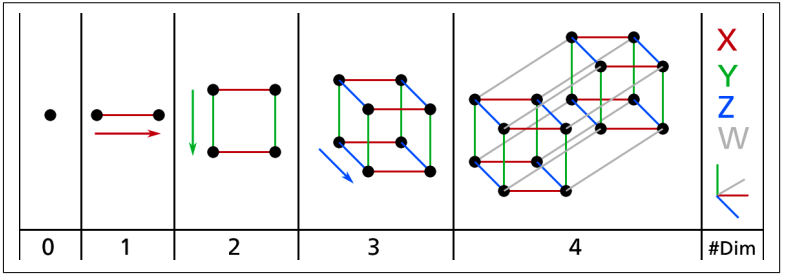

Resulta que muchas cosas se comportan de manera muy diferente en un espacio de alta dimensión. Por ejemplo, si elegimos un punto al azar en un cuadrado unitario (un cuadrado de 1 × 1), sólo tendrá una probabilidad aproximada del 0,4% de estar situado a menos de 0,001 de un borde (en otras palabras, es muy poco probable que un punto al azar sea "extremo" a lo largo de cualquier dimensión). Pero en un hipercubo unitario de 10.000 dimensiones, esta probabilidad es superior al 99,999999%. La mayoría de los puntos de un hipercubo de alta dimensión están muy cerca del borde.

He aquí una diferencia más problemática: si eliges dos puntos al azar en un cuadrado unitario, la distancia media entre esos dos puntos será de aproximadamente 0,52. Si eliges dos puntos al azar en un cubo unitario tridimensional, la distancia media será de aproximadamente 0,66. Pero, ¿qué ocurre con dos puntos elegidos al azar en un hipercubo unitario de 1.000.000 de dimensiones? La distancia media, aunque parezca mentira, será de 408,25 (aproximadamente $\sqrt{\frac{1. 000.000} {6}}$). Esto es contraintuitivo: ¿cómo pueden estar tan alejados dos puntos cuando ambos se encuentran dentro del mismo hipercubo unitario? Pues bien, en las dimensiones altas hay mucho espacio. En consecuencia, los conjuntos de datos de altas dimensiones corren el riesgo de ser muy dispersos: es probable que la mayoría de las instancias de entrenamiento estén muy alejadas entre sí. Esto también significa que una nueva instancia probablemente estará muy lejos de cualquier instancia de entrenamiento, lo que hace que las predicciones sean mucho menos fiables que en dimensiones más bajas, ya que se basarán en extrapolaciones mucho mayores. En resumen, cuantas más dimensiones tenga el conjunto de entrenamiento, mayor será el riesgo de sobreajuste.

En teoría, una solución a la maldición de la dimensionalidad podría ser aumentar el tamaño del conjunto de entrenamiento para alcanzar una densidad suficiente de instancias de entrenamiento. Por desgracia, en la práctica, el número de instancias de entrenamiento necesarias para alcanzar una densidad dada crece exponencialmente con el número de dimensiones. Con sólo 100 características (un número significativamente menor que en el problema MNIST), todas comprendidas entre 0 y 1, se necesitarían más instancias de entrenamiento que átomos en el universo observable para que las instancias de entrenamiento tuvieran una diferencia media de 0,1 entre sí, suponiendo que estuvieran distribuidas uniformemente en todas las dimensiones.

Este capítulo comienza con varias figuras para explicar los conceptos de PCA y Manifold Learning. A continuación se muestra el código para generar estas figuras.

Generemos un pequeño conjunto de datos 3D. Es una forma ovalada, rotada en el espacio 3D, con puntos distribuidos de forma desigual y con bastante ruido:

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # inicializar el conjunto de datos 3D
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # distribución desigual
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # añadir más ruido
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # cambiar un poco

# Principales métodos de reducción de la dimensionalidad

Antes de sumergirnos en algoritmos específicos de reducción de la dimensionalidad, echemos un vistazo a los dos enfoques principales para reducir la dimensionalidad: la proyección y el aprendizaje múltiple.

# Projection

En la mayoría de los problemas del mundo real, las instancias de entrenamiento no están repartidas uniformemente en todas las dimensiones. Muchas características son casi constantes, mientras que otras están muy correlacionadas. Como resultado, todas las instancias de entrenamiento se encuentran dentro (o cerca) de un subespacio de dimensiones mucho más bajas del espacio de altas dimensiones. Esto suena muy abstracto, así que veamos un ejemplo.

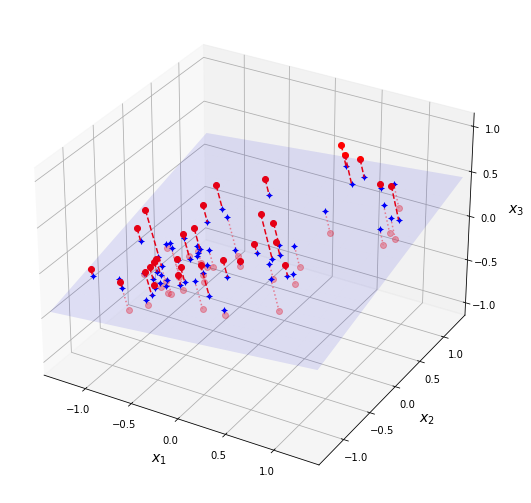

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # conjunto de datos reducido a 2D
X3D_inv = pca.inverse_transform(X2D)  # Posición 3D de las muestras proyectadas
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # coeficientes del plano de proyección
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plano
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # muestras sobre plano
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # muestras bajo plano

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# trazar primero las muestras y las líneas de proyección por debajo del plano
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # plano de proyección
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # muestras proyectadas
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# ahora trazar líneas de proyección y muestras sobre el plano
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

Observe que todas las instancias de entrenamiento se encuentran cerca de un plano: se trata de un subespacio de dimensión inferior (2D) del espacio de dimensión superior (3D). Si proyectamos cada instancia de entrenamiento perpendicularmente sobre este subespacio (representado por las líneas discontinuas cortas que conectan las instancias con el plano), obtenemos el nuevo conjunto de datos 2D que se muestra en la Figura. Y ¡tachán! Acabamos de reducir la dimensionalidad del conjunto de datos de 3D a 2D. Observe que los ejes corresponden a las nuevas características $z_1$ y $z_2$: son las coordenadas de las proyecciones sobre el plano.

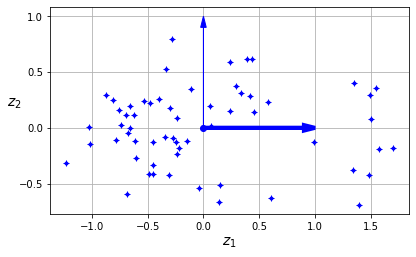

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

# Aprendizaje múltiple

Sin embargo, la proyección no siempre es el mejor enfoque para reducir la dimensionalidad. En muchos casos, el subespacio puede torcerse y girar, como en el famoso conjunto de datos de juguetes de rollo suizo representado en la Figura.

In [8]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

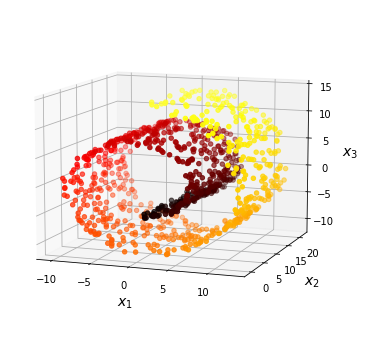

In [9]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

Simplemente proyectando sobre un plano (por ejemplo, soltando $x_3$) se aplastarían las diferentes capas del rollo suizo, como se muestra en la parte izquierda de la Figura. Lo que probablemente desee en su lugar es desenrollar el rollo suizo para obtener el conjunto de datos 2D de la parte derecha de la Figura.

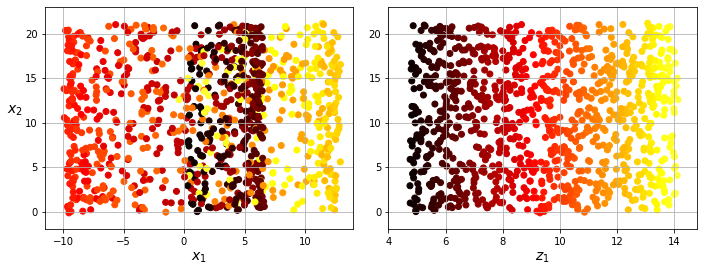

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

El rollo suizo es un ejemplo de colector 2D. En pocas palabras, un colector 2D es una forma 2D que puede doblarse y retorcerse en un espacio de dimensiones superiores. En términos más generales, un colector d-dimensional es una parte de un espacio n-dimensional (donde d < n) que localmente se asemeja a un hiperplano d-dimensional. En el caso del rollo suizo, d = 2 y n = 3: localmente se parece a un plano d-dimensional, pero se enrolla en la tercera dimensión.

Muchos algoritmos de reducción de la dimensionalidad se basan en el modelado de la matriz en la que se encuentran las instancias de entrenamiento, lo que se denomina aprendizaje de la matriz. Se basa en la suposición del maniflod, también llamada hipótesis del manyfold, que sostiene que la mayoría de los conjuntos de datos de alta dimensión del mundo real se encuentran cerca de un múltiple de dimensión mucho menor. Esta hipótesis se cumple empíricamente con mucha frecuencia.

Una vez más, pensemos en el conjunto de datos MNIST: todas las imágenes de dígitos manuscritos tienen algunas similitudes. Están formadas por líneas conectadas, los bordes son blancos y están más o menos centradas. Si se generaran imágenes al azar, sólo una fracción ridículamente pequeña de ellas se parecería a los dígitos manuscritos. En otras palabras, los grados de libertad de que dispone si intenta crear una imagen de dígitos son drásticamente inferiores a los grados de libertad que tiene si se le permite generar cualquier imagen que desee. Estas restricciones tienden a comprimir el conjunto de datos en una variedad de dimensiones inferiores.

El supuesto del manifold suele ir acompañado de otro supuesto implícito: que la tarea en cuestión (por ejemplo, clasificación o regresión) será más sencilla si se expresa en el espacio de dimensión inferior del múltiple. Por ejemplo, en la fila superior de la Figura, el rollo suizo se divide en dos clases: en el espacio tridimensional (a la izquierda), el límite de decisión sería bastante complejo, pero en el espacio 2D del manifold desenrollado (a la derecha), el límite de decisión es una línea recta.

Sin embargo, esta suposición implícita no siempre se cumple. Por ejemplo, en la fila inferior de la Figura, el límite de decisión está situado en $x_1 = 5$. Este límite de decisión parece muy simple en el espacio 3D original (un plano vertical), pero parece más complejo en el colector desenrollado (una colección de cuatro segmentos de línea independientes).

En resumen, reducir la dimensionalidad del conjunto de entrenamiento antes de entrenar un modelo suele acelerar el entrenamiento, pero no siempre conduce a una solución mejor o más sencilla; todo depende del conjunto de datos.

Espero que ahora tenga una buena idea de lo que es la maldición de la dimensionalidad y de cómo los algoritmos de reducción de la dimensionalidad pueden combatirla, especialmente cuando se cumple el supuesto del mainfold. El resto de este Notebook repasará algunos de los algoritmos más populares para la reducción de la dimensionalidad.

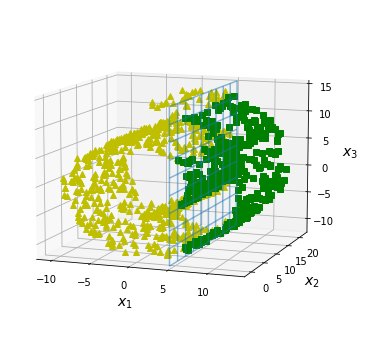

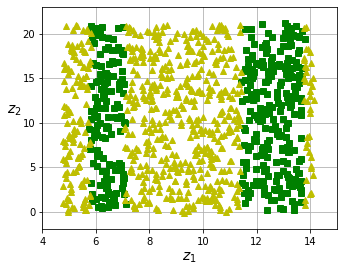

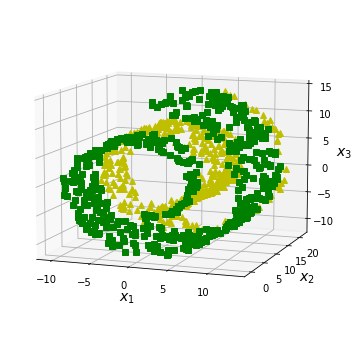

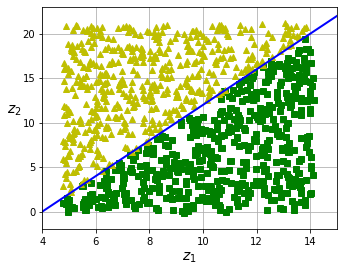

In [11]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

# PCA

El análisis de componentes principales (PCA) es, con diferencia, el algoritmo de reducción de la dimensionalidad más popular. En primer lugar, identifica el hiperplano más cercano a los datos y, a continuación, proyecta los datos sobre él.

# Preservar la varianza

Antes de poder proyectar el conjunto de entrenamiento en un hiperplano de dimensión inferior, primero hay que elegir el hiperplano adecuado. Por ejemplo, en la Figura siguiente se representa a la izquierda un conjunto de datos 2D simple, junto con tres ejes diferentes (es decir, hiperplanos 1D). A la derecha se muestra el resultado de la proyección del conjunto de datos sobre cada uno de estos ejes. Como puede verse, la proyección sobre la línea continua conserva la varianza máxima (arriba), mientras que la proyección sobre la línea de puntos conserva muy poca varianza (abajo) y la proyección sobre la línea de puntos conserva una cantidad intermedia de varianza (centro).

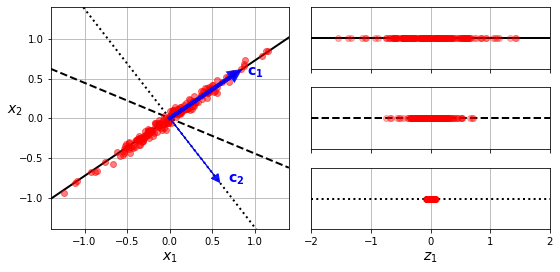

In [12]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # estirar
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotar

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

Parece razonable seleccionar el eje que conserve la máxima cantidad de varianza, ya que lo más probable es que pierda menos información que las demás proyecciones. Otra forma de justificar esta elección es que se trata del eje que minimiza la distancia cuadrática media entre el conjunto de datos original y su proyección sobre ese eje. Esta es la idea bastante simple que subyace al PCA.

## Principal Components

PCA identifica el eje que representa la mayor cantidad de varianza en el conjunto de entrenamiento. En la Figura anterior, es la línea continua. También encuentra un segundo eje, ortogonal al primero, que representa la mayor parte de la varianza restante. En este ejemplo 2D no hay elección: es la línea de puntos. Si se tratara de un conjunto de datos de mayor dimensión, PCA también encontraría un tercer eje, ortogonal a los dos ejes anteriores, y un cuarto, un quinto, etc., tantos ejes como dimensiones tenga el conjunto de datos. 

El eje $i^{nesimo}$ se denomina componente principal (CP) $i^{nesimo}$ de los datos. En la Figura anterior, el primer CP es el eje en el que se encuentra el vector $c_1$, y el segundo CP es el eje en el que se encuentra el vector $c_2$. En la primera Figura los dos primeros PC están en el plano de proyección, y el tercer PC es el eje ortogonal a ese plano. Después de la proyección, en la Figura siguiente a esa, el primer PC corresponde al eje $z_1$, y el segundo PC corresponde al eje $z_2$.

Para cada componente principal, PCA encuentra un vector unitario centrado en cero que apunta en la dirección del CP. Dado que dos vectores unitarios opuestos se encuentran en el mismo eje, la dirección de los vectores unitarios devueltos por PCA no es estable: si perturba ligeramente el conjunto de entrenamiento y ejecuta PCA de nuevo, los vectores unitarios pueden apuntar en la dirección opuesta a los vectores originales. Sin embargo, por lo general seguirán estando en los mismos ejes. En algunos casos, un par de vectores unitarios puede incluso rotar o intercambiarse (si las varianzas a lo largo de estos dos ejes están muy próximas), pero el plano que definen seguirá siendo el mismo.


The following Python code uses NumPy’s svd() function to obtain all the principal components of the 3D training set represented in Figure 8-2, then it extracts the two unit vectors that define the first two PCs:

El siguiente código Python utiliza la función svd() de NumPy para obtener todos los componentes principales del conjunto de entrenamiento 3D representado en la Figura inicial, luego extrae los dos vectores unitarios que definen los dos primeros PC:

In [13]:
import numpy as np

# X = [...]  # el pequeño conjunto de datos 3D se creó anteriormente en este cuaderno
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Nota: en principio, el algoritmo de factorización SVD devuelve tres matrices, **U**, **Σ** y **V**, tales que **X** = **UΣV**<sup>⊺</sup>, donde **U** es una matriz _m_ × _m_, **Σ** es una matriz _m_ × _n_, y **V** es una matriz _n_ × _n_. Pero la función `svd()` devuelve **U**, **s** y **V**<sup>⊺</sup> en su lugar. **s** es el vector que contiene todos los valores de la diagonal principal de las _n_ filas superiores de **Σ**. Desde **Σ** está lleno de ceros en otros lugares, usted puede reconstruir fácilmente a partir de **s**, de esta manera:

Descomposición en Valores Singulares, es una técnica matemática importante en el campo del machine learning. En su forma más básica, SVD es un método para descomponer una matriz en tres matrices distintas. 

In [14]:
# muestra cómo construir Σ a partir de s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

PCA asume que el conjunto de datos está centrado alrededor del origen. Como verá, las clases PCA de Scikit-Learn se encargan de centrar los datos por usted. Si implementa PCA usted mismo (como en el ejemplo anterior), o si utiliza otras bibliotecas, no olvide centrar los datos primero.

## Proyección a dimensiones d

Una vez identificados todos los componentes principales, puede reducir la dimensionalidad del conjunto de datos a d dimensiones proyectándolo sobre el hiperplano definido por los primeros d componentes principales. La selección de este hiperplano garantiza que la proyección preservará tanta varianza como sea posible. Por ejemplo, en la Figura inicial, el conjunto de datos 3D se proyecta hacia el plano 2D definido por los dos primeros componentes principales, preservando una gran parte de la varianza del conjunto de datos. Como resultado, la proyección 2D se parece mucho al conjunto de datos 3D original.

Para proyectar el conjunto de entrenamiento en el hiperplano y obtener un conjunto de datos reducido Xd-proj de dimensionalidad d, calcule la multiplicación matricial de la matriz del conjunto de entrenamiento X por la matriz Wd , definida como la matriz que contiene las primeras d columnas de V, como se muestra en la Ecuación.

Proyección del conjunto de entrenamiento a d dimensiones

$$X_{d-proj} = XW_d$$

El siguiente código Python proyecta el conjunto de entrenamiento en el plano definido por los dos primeros componentes principales:

In [15]:
W2 = Vt[:2].T
X2D = X_centered @ W2

Ya está. Ahora ya sabe cómo reducir la dimensionalidad de cualquier conjunto de datos proyectándolo a cualquier número de dimensiones, preservando la mayor varianza posible.

## Using Scikit-Learn

La clase PCA de Scikit-Learn utiliza SVD para implementar PCA, al igual que hicimos anteriormente en este Notebook. El siguiente código aplica PCA para reducir la dimensionalidad del conjunto de datos a dos dimensiones (tenga en cuenta que se encarga automáticamente de centrar los datos):

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

Después de ajustar el transformador PCA al conjunto de datos, su atributo components_ contiene la transposición de $W_d$: contiene una fila para cada uno de los primeros $d$ componentes principales.

In [17]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

## Explained Variance Ratio

Otra información útil es el ratio de varianza explicada de cada componente principal, disponible a través de la variable explained_variance_ratio_. El ratio indica la proporción de la varianza del conjunto de datos que se encuentra en cada componente principal. Por ejemplo, veamos los ratios de varianza explicada de los dos primeros componentes del conjunto de datos 3D representado en la Figura inicial:


In [18]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

La primera dimensión explica alrededor del 76% de la varianza, mientras que la segunda explica alrededor del 15%.

Al proyectar a 2D, perdimos alrededor del 9% de la varianza:

In [19]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742046

## Elegir el número correcto de dimensiones

En lugar de elegir arbitrariamente el número de dimensiones a las que reducir, es más sencillo elegir el número de dimensiones que suman una parte suficientemente grande de la varianza, digamos el 95% (una excepción a esta regla, por supuesto, es si está reduciendo la dimensionalidad para la visualización de datos, en cuyo caso querrá reducir la dimensionalidad a 2 o 3).

El siguiente código carga y divide el conjunto de datos MNIST y realiza el PCA sin reducir la dimensionalidad, luego calcula el número mínimo de dimensiones necesarias para preservar el 95% de la varianza del conjunto de entrenamiento:

In [20]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 

Nota: Se añadió `parser="auto"` al llamar a `fetch_openml()` para evitar una advertencia sobre el hecho de que el valor por defecto para ese parámetro cambiará en el futuro (es irrelevante en este caso). Puedes consultar la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) para más detalles.

In [21]:
d

154

A continuación, podría establecer n_componentes=d y ejecutar PCA de nuevo, pero hay una opción mejor. En lugar de especificar el número de componentes principales que desea conservar, puede establecer n_componentes como un valor flotante entre 0,0 y 1,0, indicando la proporción de varianza que desea conservar:

In [22]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

El número real de componentes se determina durante el entrenamiento y se almacena en el atributo n_components_:

In [23]:
pca.n_components_

154

Otra opción es trazar la varianza explicada en función del número de dimensiones. Normalmente habrá un codo en la curva, donde la varianza explicada deja de crecer rápidamente. En este caso, puede ver que reduciendo la dimensionalidad a unas 100 dimensiones no se perdería demasiada varianza explicada.

In [24]:
pca.explained_variance_ratio_.sum()

0.9501960192613035

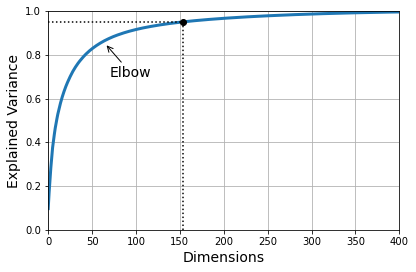

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

Por último, si está utilizando la reducción de la dimensionalidad como un paso de preprocesamiento para una tarea de aprendizaje supervisado (por ejemplo, clasificación), entonces puede ajustar el número de dimensiones como lo haría con cualquier otro hiperparámetro. Por ejemplo, el siguiente código crea un pipeline de dos pasos, primero reduciendo la dimensionalidad usando PCA, luego clasificando usando un Random Forest. A continuación, utiliza RandomizedSearchCV para encontrar una buena combinación de hiperparámetros tanto para PCA como para el clasificador de Random Forest. Este ejemplo realiza una búsqueda rápida, ajustando sólo 2 hiperparámetros, entrenando sólo 1.000 instancias y ejecutando sólo 10 iteraciones, pero si tienes tiempo, puedes realizar una búsqueda más exhaustiva:

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       

In [27]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [29]:
grid_search.best_params_

{'pca__n_components': 67}

Es interesante observar lo bajo que es el número óptimo de componentes: ¡redujimos un conjunto de datos de 784 dimensiones a sólo 23 dimensiones! Esto se debe a que hemos utilizado un Random Forest, que es un modelo bastante potente. Si en su lugar utilizáramos un modelo lineal, como un SGDClassifier, la búsqueda nos llevaría a la conclusión de que necesitamos preservar más dimensiones (unas 70).

## PCA for Compression

Tras la reducción de la dimensionalidad, el conjunto de entrenamiento ocupa mucho menos espacio. Por ejemplo, tras aplicar el PCA al conjunto de datos MNIST y conservar el 95% de su varianza, nos quedamos con 154 características, en lugar de las 784 originales. Por tanto, el conjunto de datos tiene ahora menos del 20% de su tamaño original, ¡y sólo hemos perdido el 5% de su varianza! Se trata de una relación de compresión razonable, y es fácil ver cómo una reducción de tamaño de este tipo aceleraría enormemente un algoritmo de clasificación.

También es posible descomprimir el conjunto de datos reducido a 784 dimensiones aplicando la transformación inversa de la proyección PCA. Esto no le devolverá los datos originales, ya que la proyección perdió un poco de información (dentro del 5% de varianza que se eliminó), pero probablemente se acercará a los datos originales. La distancia media al cuadrado entre los datos originales y los datos reconstruidos (comprimidos y descomprimidos) se denomina error de reconstrucción.

El método inverse_transform() nos permite descomprimir el conjunto de datos MNIST reducido a 784 dimensiones:

In [30]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [31]:
X_recovered = pca.inverse_transform(X_reduced)

La siguiente Figura muestra algunos dígitos del conjunto de entrenamiento original (a la izquierda), y los dígitos correspondientes tras la compresión y descompresión. Puede verse que hay una ligera pérdida de calidad de imagen, pero los dígitos siguen intactos en su mayor parte.

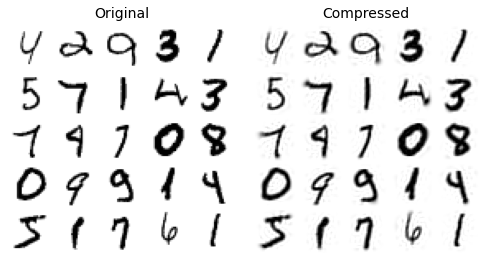

In [32]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

## Randomized PCA

Si establece el hiperparámetro svd_solver en "aleatorio", Scikit-Learn utiliza un algoritmo estocástico llamado PCA aleatorio que encuentra rápidamente una aproximación de los primeros d componentes principales. Su complejidad computacional es $O(m \times d^2 ) + O(d^3)$, en lugar de $O(m \times n^2 ) + O(n^3)$ para el enfoque SVD completo, por lo que es mucho más rápido que el SVD completo cuando d es mucho menor que n:

In [33]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Por defecto, svd_solver se establece en "auto": Scikit-Learn utiliza automáticamente el algoritmo PCA aleatorio si max(m, n) > 500 y n_componentes es un número entero menor que el 80% de min(m, n), o de lo contrario utiliza el enfoque SVD completo. Así que el código anterior utilizaría el algoritmo PCA aleatorio incluso si se elimina el argumento svd_solver="randomized", ya que 154 < 0.8 × 784. Si desea forzar a Scikit-Learn a utilizar SVD completo para obtener un resultado ligeramente más preciso, puede establecer el hiperparámetro svd_solver como "full".

## Incremental PCA

Uno de los problemas de las implementaciones anteriores de PCA es que requieren que todo el conjunto de entrenamiento quepa en la memoria para que el algoritmo pueda ejecutarse. Afortunadamente, se han desarrollado algoritmos de PCA incremental (IPCA) que permiten dividir el conjunto de entrenamiento en minilotes y alimentarlos de uno en uno. Esto es útil para grandes conjuntos de entrenamiento y para aplicar el PCA en línea (es decir, sobre la marcha, a medida que llegan nuevas instancias).

El siguiente código divide el conjunto de entrenamiento MNIST en 100 mini-lotes (utilizando la función array_split() de NumPy) y los alimenta a la clase IncrementalPCA de Scikit-Learn para reducir la dimensionalidad del conjunto de datos MNIST a 154 dimensiones, igual que antes. Tenga en cuenta que debe llamar al método partial_fit() con cada minilote, en lugar de al método fit() con todo el conjunto de entrenamiento:

In [34]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

**Usando la clase `memmap` de NumPy - un mapa de memoria a un array almacenado en un fichero binario en disco.**

Creemos la instancia `memmap`, copiemos el conjunto de entrenamiento MNIST en ella, y llamemos a `flush()` que asegura que cualquier dato aún en la caché se guarda en el disco. Esto lo haría típicamente un primer programa:

In [35]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # podría ser un bucle en su lugar, guardando los datos trozo a trozo
X_mmap.flush()

A continuación, otro programa cargaría los datos y los utilizaría para el entrenamiento:

In [36]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

Sólo se guardan en disco los datos binarios sin procesar, por lo que es necesario especificar el tipo de datos y la forma de la matriz al cargarla. Si omite la forma, np.memmap() devuelve una matriz 1D

Para conjuntos de datos de dimensiones muy altas, PCA puede ser demasiado lento. Como ha visto antes, incluso si utiliza PCA aleatorio, su complejidad computacional sigue siendo $O(m \times d^2) + O(d^3)$, por lo que el número objetivo de dimensiones d no debe ser demasiado grande. Si se trata de un conjunto de datos con decenas de miles de características o más (por ejemplo, imágenes), entonces el entrenamiento puede ser demasiado lento: en este caso, se debe considerar el uso de la proyección aleatoria en su lugar.

# Random Projection

Como su nombre indica, el algoritmo de proyección aleatoria proyecta los datos a un espacio de dimensiones inferiores utilizando una proyección lineal aleatoria. Puede parecer una locura, pero resulta que es muy probable que esa proyección aleatoria preserve bastante bien las distancias, como demostraron matemáticamente William B. Johnson y Joram Lindenstrauss en un famoso lema. "Dos casos similares seguirán siendo similares después de la proyección, y dos casos muy diferentes seguirán siendo muy diferentes."

Evidentemente, cuantas más dimensiones se reduzcan, más información se perderá y más se distorsionarán las distancias. Entonces, ¿cómo se puede elegir el número óptimo de dimensiones? Pues bien, Johnson y Lindenstrauss idearon una ecuación que determina el número mínimo de dimensiones que hay que conservar para garantizar -con alta probabilidad- que las distancias no cambien más allá de una tolerancia dada. Por ejemplo, si tenemos un conjunto de datos que contiene m = 5.000 instancias con n = 20.000 características cada una, y no queremos que la distancia al cuadrado entre dos instancias cambie más de $ε = 10%$, entonces debemos proyectar los datos hasta $d$ dimensiones, con $d ≥ 4 log(m) / (½ ε² - ⅓ ε³)$, lo que equivale a 7.300 dimensiones. ¡Es una reducción de dimensionalidad bastante significativa! Observe que la ecuación no utiliza n, sólo se basa en m y ε. Esta ecuación se implementa mediante la función johnson_lindenstrauss_min_dim():

**Atención**: esta sección utilizará cerca de 2,5 GB de RAM. Si su ordenador se queda sin memoria, reduzca _m_ y _n_:

In [37]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

Ahora podemos generar una matriz aleatoria P de forma [d, n], en la que cada elemento se muestrea aleatoriamente a partir de una distribución gaussiana con media 0 y varianza 1 / d, y utilizarla para proyectar un conjunto de datos de n dimensiones a d:

In [39]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = raíz cuadrada de la varianza

X = np.random.randn(m, n)  # generar un conjunto de datos falso
X_reduced = X @ P.T

Eso es todo. Es sencillo y eficaz, y no requiere entrenamiento: lo único que necesita el algoritmo para crear la matriz aleatoria es la forma del conjunto de datos. Los datos en sí no se utilizan para nada.

Scikit-Learn ofrece una clase GaussianRandomProjection para hacer exactamente lo que acabamos de hacer: cuando se llama a su método fit(), utiliza johnson_lindenstrauss_min_dim() para determinar la dimensionalidad de salida, luego genera una matriz aleatoria, que almacena en el atributo components_. Luego, cuando se llama a transform(), utiliza esta matriz para realizar la proyección. Al crear el transformador, puede establecer eps si desea ajustar ε (por defecto es 0,1), y n_componentes si desea forzar una dimensionalidad de destino específica d. El siguiente ejemplo de código da el mismo resultado que el código anterior (también puede verificar que gaussian_rnd_proj.components_ es igual a P):

In [40]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

Scikit-Learn también proporciona un segundo transformador de proyección aleatoria, conocido como SparseRandomProjection. Determina la dimensionalidad objetivo del mismo modo, genera una matriz aleatoria de la misma forma y realiza la proyección de forma idéntica. La principal diferencia es que la matriz aleatoria es dispersa. Esto significa que utiliza mucha menos memoria: ¡unos 25 MB en lugar de los casi 1,2 GB del ejemplo anterior! Y también es mucho más rápido, tanto para generar la matriz aleatoria como para reducir la dimensionalidad: aproximadamente un 50% más rápido en este caso. Además, si la entrada es dispersa, la transformación la mantiene dispersa (a menos que se establezca dense_output=True). Por último, disfruta de la misma propiedad de preservación de la distancia que el enfoque anterior, y la calidad de la reducción de la dimensionalidad es comparable. En resumen, suele ser preferible utilizar este transformador en lugar del primero, especialmente para conjuntos de datos grandes o dispersos.

La proporción r de elementos distintos de cero en la matriz aleatoria dispersa se denomina densidad. Por defecto, es igual a $\frac{1}{\sqrt{n}}$. Con 20.000 características, esto significa que sólo 1 de cada ~141 celdas de la matriz aleatoria es distinta de cero: ¡eso es bastante disperso! Puede establecer la densidad hiperparámetro a otro valor si lo prefiere. Cada celda de la matriz aleatoria dispersa tiene una probabilidad r de ser distinta de cero, y cada valor distinto de cero es -v o +v (ambos igualmente probables), donde $v = \frac{1}{\sqrt{dr}}$.

Si desea realizar la transformación inversa, primero debe calcular la pseudoinversa de la matriz de componentes mediante la función pinv() de SciPy y, a continuación, multiplicar los datos reducidos por la transposición de la pseudoinversa:

**Atención**, la siguiente célula puede tardar varios minutos en ejecutarse:

In [41]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

El cálculo del pseudoinverso puede llevar mucho tiempo si la matriz de componentes es grande, ya que la complejidad computacional de pinv() es $O(dn²)$ si d < n, o $O(nd²)$ en caso contrario.

In [42]:
# Comparación de rendimiento entre RP gaussiano y RP disperso

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
4.05 s ± 327 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
3.85 s ± 647 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
11.1 s ± 507 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
5.37 s ± 640 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


En resumen, la proyección aleatoria es un algoritmo de reducción de la dimensionalidad sencillo, rápido, eficiente en el uso de la memoria y sorprendentemente potente que debe tener en cuenta, especialmente cuando trabaje con conjuntos de datos de gran dimensión.

# LLE

La incrustación lineal local (LLE) es una técnica de reducción no lineal de la dimensionalidad (NLDR). Es una técnica de aprendizaje manifold que no se basa en proyecciones, a diferencia del PCA y la proyección aleatoria. En pocas palabras, LLE funciona midiendo en primer lugar cómo se relaciona linealmente cada instancia de entrenamiento con sus vecinos más cercanos y, a continuación, buscando una representación de baja dimensión del conjunto de entrenamiento en la que estas relaciones locales se conserven mejor. Este enfoque lo hace especialmente bueno para desenrollar variedades retorcidas, sobre todo cuando no hay demasiado ruido.

El siguiente código crea un rollo suizo y utiliza la clase ding LocallyLinearEmbed de Scikit-Learn para desenrollarlo:

In [43]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

La variable t es un array NumPy 1D que contiene la posición de cada instancia a lo largo del eje rodado del rollo suizo. No la utilizamos en este ejemplo, pero puede usarse como objetivo para una tarea de regresión no lineal.

En la siguiente Figura se muestra el conjunto de datos 2D resultante. Como puede verse, el rollo suizo está completamente desenrollado, y las distancias entre instancias están localmente bien conservadas.

Sin embargo, las distancias no se conservan a mayor escala: el rollo suizo desenrollado debería ser un rectángulo, no este tipo de banda estirada y retorcida. No obstante, LLE ha hecho un buen trabajo modelando el manifold.

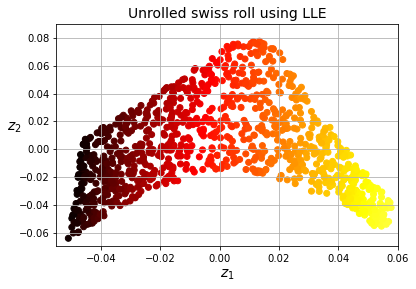

In [44]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()


Así es como funciona el LLE: para cada instancia de entrenamiento $x^(i)$ , el algoritmo identifica sus k vecinos más cercanos (en el código anterior k = 10), luego intenta reconstruir $x^{(i)}$ como una función lineal de estos vecinos. Más concretamente, trata de encontrar los pesos $w_{i,j}$ tal que la distancia al cuadrado entre $x^{(i)}$ y $\sum_{j=1}^{m} w_{i,j}x^j$ sea lo más pequeña posible, suponiendo $w_{i,j} = 0 si x (j)$ no es uno de los k-vecinos más cercanos de $x^{(i)}$ . Así, el primer paso de LLE es el problema de optimización con restricciones, donde W es la matriz de pesos que contiene todos los pesos $w_{i,j}$. La segunda restricción simplemente normaliza los pesos para cada instancia de entrenamiento $x^{(i)}$.

La implementación LLE de Scikit-Learn tiene la siguiente complejidad computacional: $O(m log(m)n log(k))$ para encontrar los k vecinos más cercanos, $O(mnk^3)$ para optimizar los pesos, y $O(dm^2)$ para construir las representaciones de baja dimensión. Desgraciadamente, el m^2 del último término hace que este algoritmo no se adapte bien a conjuntos de datos muy grandes. Como se puede ver, LLE es bastante diferente de las técnicas de proyección, y es significativamente más complejo, pero también puede construir representaciones de baja dimensión mucho mejores, especialmente si los datos son no lineales.

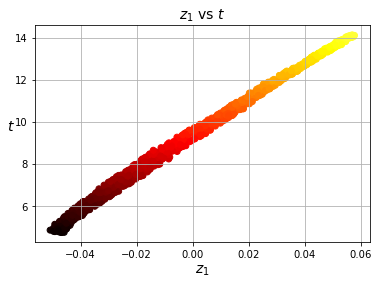

In [45]:
# muestra lo bien correlacionado que está z1 con t: LLE funcionó bien
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

Nota: se añadió `normalized_stress=False` a continuación para evitar una advertencia sobre el hecho de que el valor por defecto para ese hiperparámetro cambiará en el futuro. Por favor, consulte la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) para más detalles.

# Otras técnicas de reducción de la dimensionalidad

Antes de concluir este Notebook, echemos un vistazo rápido a otras técnicas populares de reducción de la dimensionalidad disponibles en Scikit-Learn:

- sklearn.manifold.MDS

El escalado multidimensional (MDS) reduce la dimensionalidad a la vez que intenta preservar las distancias entre las instancias. La proyección aleatoria lo hace para datos de alta dimensión, pero no funciona bien en datos de baja dimensión.

- sklearn.manifold.Isomap

Isomap crea un grafo conectando cada instancia a sus vecinos más cercanos, luego reduce la dimensionalidad mientras intenta preservar las distancias geodésicas entre las instancias. La distancia geodésica entre dos nodos en un grafo es el número de nodos en el camino más corto entre estos nodos.

- sklearn.manifold.TSNE

t-distributed stochastic neighbor embedding (t-SNE) reduce la dimensionalidad a la vez que intenta mantener las instancias similares cerca y las instancias disímiles separadas. Se utiliza principalmente para la visualización, en particular para visualizar grupos de instancias en un espacio de alta dimensión. Por ejemplo, en los ejercicios del final de este NoteBook utilizará t-SNE para visualizar un mapa 2D de las imágenes MNIST.

- sklearn.discriminant_analysis.LinearDiscriminantAnalysis

El análisis discriminante lineal (LDA) es un algoritmo de clasificación lineal que, durante el entrenamiento, aprende los ejes más discriminativos entre las clases. Estos ejes pueden utilizarse para definir un hiperplano sobre el que proyectar los datos. La ventaja de este enfoque es que la proyección mantendrá las clases lo más separadas posible, por lo que el LDA es una buena técnica para reducir la dimensionalidad antes de ejecutar otro algoritmo de clasificación (a menos que el LDA por sí solo sea suficiente).


In [46]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [47]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

La siguiente Figura muestra los resultados de MDS, Isomap y t-SNE en el rollo suizo. MDS consigue aplanar el rollo suizo sin perder su curvatura global, mientras que Isomap la elimina por completo. Dependiendo de la tarea posterior, preservar la estructura a gran escala puede ser bueno o malo. t-SNE hace un trabajo razonable aplanando el rollo suizo, preservando un poco de curvatura, y también amplifica los clusters, desgarrando el rollo. Una vez más, esto puede ser bueno o malo, dependiendo de la tarea posterior.


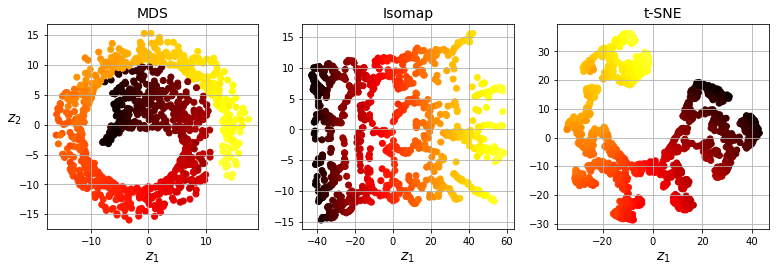

In [49]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Extra Material – Kernel PCA

In [50]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

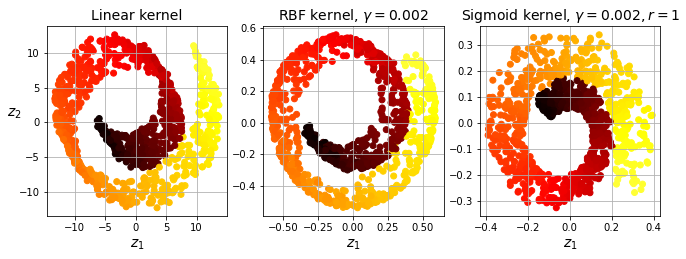

In [51]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()